In [33]:
import numpy as np
import joblib
from typing import Tuple, List, Dict
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
import tsfel
import matplotlib.pyplot as plt

# allowing for imports from PrevOccupAI dataset project
import sys 
from pathlib import Path
project_path = Path("C:/Users/srale/PycharmProjects/PrevOccupAI_Dataset")
sys.path.append(str(project_path))

# imports from PrevOccupAI dataset
from raw_data_processor.load_sensor_data import load_data_from_same_recording
from feature_extractor.feature_extractor import _pre_process_sensors, trim_data
from HAR.post_process import threshold_tuning, heuristics_correction, expand_classification
from HAR.load import load_production_model

In [12]:
# define constants
FS = 100 # sampling frequency
W_SIZE = 5 # 5 second window

PROB_THRESHOLD = 0.85 # threshold for probabolity thresholding
MIN_DURATIONS = {0: 20, 1: 30, 2: 5} # durations for 0 (sitting), 1 (standing), 2 (walking)

In [13]:
def apply_classification_pipeline(features: np.ndarray, har_model: RandomForestClassifier, w_size: float,
                              fs: int, threshold: float, min_durations: Dict[int,int]) -> Tuple[List[int], List[int]]:
    """
    Applies classification pipeline. The classification pipeline consists of:
    
    1. Perform classification using a Random Forest
    2. Apply threshold tuning label correction
    3. Apply heuristics-based label correction


    :param features: numpy.array of shape (n_samples, n_features) containing the features
    :param har_model: object from RandomForestClassifier
    :param w_size: window size in seconds
    :param fs: the sampling frequency
    :param threshold: The probability margin threshold for adjusting predictions. Default is 0.1.
    :param min_durations: Dictionary mapping each class label to its minimum segment duration in seconds.
    :return: A tuple containing:
        - List[int]: Labels for each window.
        - List[int]: Labels expanded to the original sampling frequency
    """

    # classify the data - vanilla model
    y_pred = har_model.predict(features)

    # get class probabilities
    y_pred_proba = har_model.predict_proba(features)

    # apply threshold tuning
    y_pred_tt = threshold_tuning(y_pred_proba, y_pred,0,1, threshold)

    # apply heuristics
    y_pred_heur = heuristics_correction(y_pred, w_size, min_durations)

    # combine tt with heuristics
    y_pred_tt_heur = heuristics_correction(y_pred_tt, w_size, min_durations)

    # expand the predictions to the size of the original signal
    y_pred_tt_heur_expanded = expand_classification(y_pred_tt_heur, w_size = w_size, fs=fs)

    return y_pred_tt_heur, y_pred_tt_heur_expanded


In [30]:
# define path to folder containing the data
data_folder_path = "E:\\Backup PrevOccupAI data\\Prevoccupai_HAR\\work_simulation\\raw_data\\S005\\2024-07-29_11-00-00"

# define sensors to load
sensors = ['ACC', 'GYR', 'MAG']

# load config file
cfg = tsfel.load_json("E:\\best_model\\cfg_file_production_model.json")

# load the model
model, model_features = load_production_model("E:\\best_model\\HAR_model_500.joblib")

model: RandomForestClassifier

hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

classes: [0 1 2]

number of features: 30
features: ['x_ACC_Interquartile range' 'x_ACC_Max' 'x_ACC_Median frequency'
 'x_ACC_Min' 'x_GYR_Max' 'x_GYR_Median frequency' 'x_GYR_Min'
 'x_GYR_Power bandwidth' 'x_MAG_Interquartile range'
 'x_MAG_Power bandwidth' 'y_ACC_Interquartile range' 'y_ACC_Max'
 'y_ACC_Max power spectrum' 'y_ACC_Power bandwidth'
 'y_GYR_Interquartile range' 'y_GYR_Max' 'y_GYR_Median frequency'
 'y_GYR_Min' 'y_GYR_Power bandwidth' 'y_MAG_Interquartile range'
 'y_MAG_Power bandwidth' 'z_ACC_Interquartile range' 'z_ACC

In [23]:
# load the data
subdata = load_data_from_same_recording(data_folder_path, sensors, fs=FS, padding_type='same')

# convert data to numpy array and remove time ('t') column
sensor_data = subdata.values[:, 1:]

# get the sensor names
sensor_names = subdata.columns.values[1:]
print(f"loaded sensors: {sensor_names}")

--> Loading data: 100%|██████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]
Padding data to ensure all data begins and ends on the same timestamp.: 100%|████████████| 3/3 [00:00<00:00, 16.20it/s]
Ensurig equidistant sampling by resampling data to 100 Hz: 100%|█████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


loaded sensors: ['x_ACC' 'y_ACC' 'z_ACC' 'x_GYR' 'y_GYR' 'z_GYR' 'x_MAG' 'y_MAG' 'z_MAG']


In [26]:
#  pre-process the data
sensor_data = _pre_process_sensors(sensor_data, sensor_names)

# remove impulse response
sensor_data = sensor_data[250:, :]

# trim the data to accomodate full windowing
sensor_data, to_trim = trim_data(sensor_data, w_size=W_SIZE, fs=FS)

# extract the features
features = tsfel.time_series_features_extractor(cfg, sensor_data, window_size=int(W_SIZE*FS), fs=FS, header_names=sensor_names)

--> pre-processing ACC sensor
--> pre-processing GYR sensor
--> pre-processing MAG sensor
The ROT sensor is not in the loaded data. Skipping the pre-processing of this sensor.


In [31]:
y_pred, y_pred_exp = apply_classification_pipeline(features[model_features], model, w_size=W_SIZE, fs=FS, threshold=PROB_THRESHOLD, min_durations=MIN_DURATIONS)

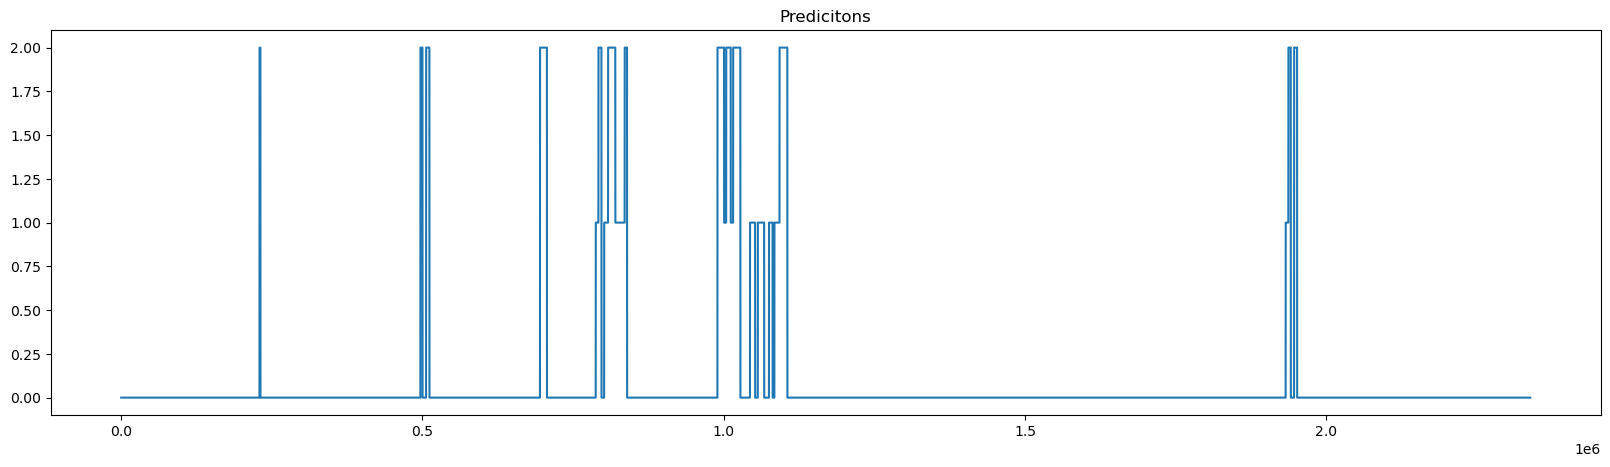

In [37]:
plt.figure(figsize=(20, 5))  
plt.plot(y_pred_exp) 
plt.title("Predicitons")
plt.show()   